# 1. Install required packages

In [1]:

!pip install tensorflow transformers rouge_score pandas numpy scikit-learn
!pip install torch

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense

from sklearn.model_selection import train_test_split

from transformers import EncoderDecoderModel, BertTokenizer, Trainer, TrainingArguments
from rouge_score import rouge_scorer

print("TensorFlow version:", tf.__version__)


c:\Users\USER\Documents\Python\arkaV\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



TensorFlow version: 2.19.0


### Loading the dataset

In [2]:
import pandas as pd

file_path = "DiaglougeData_v1.csv"

data = pd.read_csv(file_path, engine="python", on_bad_lines="skip")
data.head()

,id,dialogue,summary
0,13862856,"Hannah: Hey, do you have Betty's number?\nAman...",Hannah needs Betty's number but Amanda doesn't...
1,13729565,Eric: MACHINE!\r\nRob: That's so gr8!\r\nEric:...,Eric and Rob are going to watch a stand-up on ...
2,13680171,"Lenny: Babe, can you help me with something?\r...",Lenny can't decide which trousers to buy. Bob ...
3,13729438,"Will: hey babe, what do you want for dinner to...",Emma will be home soon and she will let Will k...
4,13828600,"Ollie: Hi , are you in Warsaw\r\nJane: yes, ju...",Jane is in Warsaw. Ollie and Jane has a party....


## Preprocessing

### (Check for missing values)

In [3]:
print("Missing values before handling:\n", data.isnull().sum())


Missing values before handling:
 id          0
dialogue    0
summary     0
dtype: int64


### (Removing emoji and special charecters)

In [4]:
import re
def remove_emoji(text):
    if not isinstance(text, str):
        return text
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags
                               u"\U00002702-\U000027B0"  # additional symbols
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#ID
data['id'] = data['id'].astype(str).str.split('-').str[0].astype(int)

# Dialoge- Remove emojis and strip extra spaces
data['dialogue'] = data['dialogue'].apply(lambda x: remove_emoji(x).strip().lower() if isinstance(x, str) else x)

# Summary- Remove emojis and strip extra spaces
data['summary'] = data['summary'].apply(lambda x: remove_emoji(x).strip().lower() if isinstance(x, str) else x)

# Remove special characters and numbers from 'dialogue' and 'summary' columns
data['dialogue'] = data['dialogue'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x) if isinstance(x, str) else x)
data['summary'] = data['summary'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x) if isinstance(x, str) else x)


# Remove duplicate rows based on 'id' or other relevant columns
data.drop_duplicates(subset=['id'], keep='first', inplace=True)


print(data.head())

         id                                           dialogue  \
0  13862856  hannah hey do you have bettys number\namanda l...   
1  13729565  eric machine\r\nrob thats so gr\r\neric i know...   
2  13680171  lenny babe can you help me with something\r\nb...   
3  13729438  will hey babe what do you want for dinner toni...   
4  13828600  ollie hi  are you in warsaw\r\njane yes just b...   

                                             summary  
0  hannah needs bettys number but amanda doesnt h...  
1  eric and rob are going to watch a standup on y...  
2  lenny cant decide which trousers to buy bob ad...  
3  emma will be home soon and she will let will know  
4  jane is in warsaw ollie and jane has a party j...  


### (Step-words removal)

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
import spacy

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('punkt_tab')

# Create stopwords list and extend with punctuation and custom words
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['one', 'two', 'go', 'goes', 'get', 'also', 'however', 'tells']
stopwords_list += [str(i) for i in range(10)]  # Convert digits to strings if needed

# Build an English vocabulary set from NLTK words corpus
english_vocab = set(w.lower() for w in words.words())

# Load spaCy's English model for lemmatization (ensure en_core_web_sm is installed)
nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    # Convert to lowercase and apply regex substitutions for normalization
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r'\W', ' ', text)       # Remove non-word characters
    text = re.sub(r'\s+', ' ', text)      # Remove extra spaces
    text = re.sub(r'\d+', ' ', text)      # Remove digits
    text = text.strip()

    # Tokenize the text
    tokens = word_tokenize(text)
    # Re-join to ensure consistency for spaCy processing
    text = ' '.join(tokens)

    # Use spaCy for lemmatization
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]

    # Remove stopwords
    lemmas = [w for w in lemmas if w not in stopwords_list]

    # Filter out words not in the English vocabulary
    lemmas = [w for w in lemmas if w in english_vocab]

    # Return the cleaned text as a string
    return ' '.join(lemmas)

# Overwrite the original dialogue and summary columns with cleaned text
data['dialogue'] = data['dialogue'].apply(clean_text)
data['summary'] = data['summary'].apply(clean_text)

# Verify the cleaned columns
print(data[['dialogue', 'summary']].head())



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


                                            dialogue  \
0  hey number amanda check amanda sorry find aman...   
1  eric machine rob eric know show see russian ro...   
2  lenny babe help something bob sure lenny pick ...   
3  hey babe want dinner tonight emma even worry t...   
4  ollie hi warsaw jane yes back free din th olli...   

                                             summary  
0              need number amanda need contact larry  
1                                     eric rob watch  
2  lenny decide trouser buy bob advise lenny topi...  
3                            emma home soon let know  
4  jane warsaw ollie jane party jane lose calenda...  


# Part-2 LSTM based Encoder-Decoder 

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.4155 - loss: 8.4256 - val_accuracy: 0.8464 - val_loss: 7.0374
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8324 - loss: 6.8742 - val_accuracy: 0.8464 - val_loss: 7.1058
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8244 - loss: 6.6883 - val_accuracy: 0.8464 - val_loss: 7.0383
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.8228 - loss: 6.6059 - val_accuracy: 0.8472 - val_loss: 7.0667
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8301 - loss: 6.5324 - val_accuracy: 0.8472 - val_loss: 7.0765
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8193 - loss: 6.5209 - val_accuracy: 0.8404 - val_loss: 7.0720
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8115 - loss: 6.4914 - val_accuracy: 0.8277 - val_loss: 7.1230
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.7908 - loss: 6.4917 - val_accuracy: 0.8469 - val_loss:

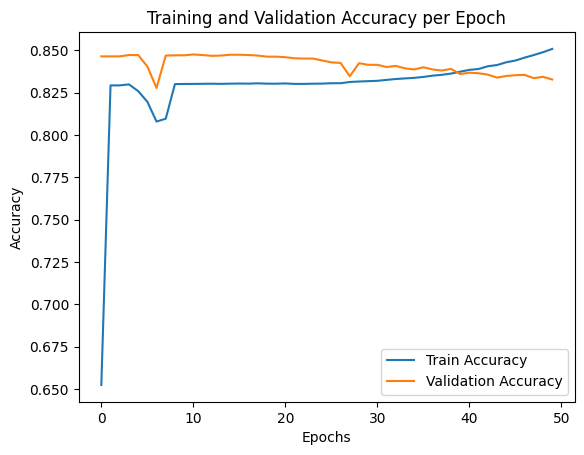

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 225)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 49)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 225, 128)  │    640,000 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 225)       │          0 │ encoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 49, 128)   │    640,000 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 256),     │    394,240 │ encoder_embeddin… │
│                     │ (None, 256),      │            │ not_equal[0][0]   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 49, 256), │    394,240 │ decoder_embeddin… │
│                     │ (None, 256),      │            │ encoder_lstm[0][… │
│                     │ (None, 256)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output      │ (None, 49, 5000)  │  1,285,000 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,060,442 (38.38 MB)

 Trainable params: 3,353,480 (12.79 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,706,962 (25.59 MB)

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from sklearn.model_selection import train_test_split

# Define vocabulary size (Limit to reduce memory usage)
VOCAB_SIZE = 5000
EMBEDDING_DIM = 128  # Smaller embedding size reduces memory load

# Tokenization
dialogue_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
dialogue_tokenizer.fit_on_texts(data['dialogue'])

summary_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
summary_tokenizer.fit_on_texts(data['summary'])

# Convert text to sequences of integers
dialogue_sequences = dialogue_tokenizer.texts_to_sequences(data['dialogue'])
summary_sequences = summary_tokenizer.texts_to_sequences(data['summary'])

# Define max lengths (Adjust based on dataset)
MAX_LEN_DIALOGUE = 225  # Fixed length for consistency
MAX_LEN_SUMMARY = 50

# Pad sequences
X_padded = pad_sequences(dialogue_sequences, maxlen=MAX_LEN_DIALOGUE, padding='post')
y_padded = pad_sequences(summary_sequences, maxlen=MAX_LEN_SUMMARY, padding='post')

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_padded, test_size=0.3, random_state=42)

# Define LSTM Model with Embeddings
latent_dim = 256

# Encoder
encoder_inputs = Input(shape=(MAX_LEN_DIALOGUE,), name="encoder_input")
encoder_embedding = Embedding(VOCAB_SIZE, EMBEDDING_DIM, mask_zero=True, name="encoder_embedding")(encoder_inputs)
encoder_lstm, state_h, state_c = LSTM(latent_dim, return_state=True, name="encoder_lstm")(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(MAX_LEN_SUMMARY - 1,), name="decoder_input")  # Shifted left for training
decoder_embedding = Embedding(VOCAB_SIZE, EMBEDDING_DIM, mask_zero=True, name="decoder_embedding")(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name="decoder_lstm")
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(VOCAB_SIZE, activation='softmax', name="decoder_output")
decoder_outputs = decoder_dense(decoder_outputs)

# Define model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit([X_train, y_train[:, :-1]], y_train[:, 1:],  # Shift decoder target
                    batch_size=64,
                    epochs=50,
                    validation_split=0.1)

# Plot accuracy per epoch
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy per Epoch')
plt.show()

# Display model summary
model.summary()


# Part-3 BERT Models from Hugging Face


### Model 1: 
#### Overview
🔹 **Full Name:**
facebook/bart-large-cnn

🔹 **Base Model:**
BART (Bidirectional and Auto-Regressive Transformer)

🔹 **Fine-tuned On:**
CNN/DailyMail News Dataset

🔹 **Task:**
Abstractive Summarization
(Generates summaries that paraphrase content rather than extract exact sentences)

🔹 **Developer:**
Facebook AI

#### Architecture
🔸 **Type:**
Sequence-to-Sequence (Encoder–Decoder Transformer)

🔸 **Encoder:**
Inspired by BERT
→ Bidirectional context understanding

🔸 **Decoder:**
Inspired by GPT
→ Auto-regressive generation

🔸 **Pretraining Objective:**

Denoising Autoencoding
(Learn to reconstruct corrupted text)

Masked text infilling

Sentence permutation



In [8]:
from transformers import pipeline

text_summarizer1 = pipeline("summarization", model="facebook/bart-large-cnn")


Device set to use cpu


In [16]:
dialogue = """Madeline: Hey, the smog is so bad today.
Josephine: Hey, tell me about it, I just went grocery shopping.
Josephine: And I came back with a terrible cough.
Madeline: You shouldn't even leave the house today.
Madeline: Or open the windows!
Josephine: Ugh, this is dreadful.
Josephine: Ppl really have to stop using plastic & other crap to heat their houses.
Madeline: I know, they should send more patrols to control them.
Josephine: We're killing our environment.
Madeline: And eventually ourselves!
Josephine: I'm looking into buying one of those special anti-smog masks b/c my scarf is no longer helping...
Madeline: I've already got one. It works well and I'm not coughing lately.
Josephine: Enjoy another day locked in.
Madeline: Likewise, take care.
Madeline: See you when the wind blows the smog away!"""




In [11]:
bert_summary1 = text_summarizer1(dialogue, max_length=80, min_length=10, do_sample=False)
print(bert_summary1)


[{'summary_text': "Josephine: Ppl really have to stop using plastic & other crap to heat their houses. Madeline: You shouldn't even leave the house today."}]


### Model 2: 
#### Overview
🔹 **Full Name:**
philschmid/bart-large-cnn-samsum

🔹 **Base Model:**
BART (Bidirectional and Auto-Regressive Transformer)

🔹 **Fine-tuned On:**
SAMSum Dataset (Dialogue Summarization)

🔹 **Task:**
Abstractive Summarization
(Generates concise summaries for dialogues)

🔹 **Developer:**
Philipp Schmid

#### Architecture
🔸 **Type:***
Sequence-to-Sequence (Encoder–Decoder Transformer)

🔸 **Encoder:**
Similar to BERT (Bidirectional)

🔸 **Decoder:**
Similar to GPT (Auto-regressive)

🔸 **Pretraining Objective:**
Denoising Autoencoding

Masked text infilling

Sentence permutation

🔸 **Fine-tuning Objective:**
Optimized for Dialogue Summarization using the SAMSum dataset

In [12]:
text_summarizer2 = pipeline("summarization", model="philschmid/bart-large-cnn-samsum")

bert_summary2 = text_summarizer2(dialogue, max_length=80, min_length=10, do_sample=False)
print(bert_summary2)

Device set to use cpu


[{'summary_text': "The smog is bad today. Josephine went grocery shopping and came back with a terrible cough. She's considering buying an anti-smog mask. Madeline has one and it works well."}]


### ROUGE-1

### Prediction for LSTM Model

In [ ]:
def generate_summary_lstm(dialogue_text, dialogue_tokenizer, summary_tokenizer, model, MAX_LEN_DIALOGUE, MAX_LEN_SUMMARY):
    dialogue_sequence = dialogue_tokenizer.texts_to_sequences([dialogue_text])
    dialogue_padded = pad_sequences(dialogue_sequence, maxlen=MAX_LEN_DIALOGUE, padding='post')

    # Get the <start> token index from summary tokenizer
    start_token = summary_tokenizer.word_index.get('<start>', 1)
    target_seq = [start_token]

    decoded_sentence = ''

    for _ in range(MAX_LEN_SUMMARY):
        target_seq_padded = pad_sequences([target_seq], maxlen=MAX_LEN_SUMMARY - 1, padding='post')

        output_tokens = model.predict([dialogue_padded, target_seq_padded], verbose=0)
        sampled_token_index = np.argmax(output_tokens[0, 0, :])  # Always take first timestep

        sampled_word = summary_tokenizer.index_word.get(sampled_token_index, '')

        if sampled_word == '<end>' or sampled_word == '' or sampled_token_index == 0:
            break

        decoded_sentence += ' ' + sampled_word
        target_seq.append(sampled_token_index)

    return decoded_sentence.strip()


In [23]:
# Define your dialogue input
dialogue = """Madeline: Hey, the smog is so bad today.
Josephine: Hey, tell me about it, I just went grocery shopping.
Josephine: And I came back with a terrible cough.
Madeline: You shouldn't even leave the house today.
Madeline: Or open the windows!
Josephine: Ugh, this is dreadful.
Josephine: Ppl really have to stop using plastic & other crap to heat their houses.
Madeline: I know, they should send more patrols to control them.
Josephine: We're killing our environment.
Madeline: And eventually ourselves!
Josephine: I'm looking into buying one of those special anti-smog masks b/c my scarf is no longer helping...
Madeline: I've already got one. It works well and I'm not coughing lately.
Josephine: Enjoy another day locked in.
Madeline: Likewise, take care.
Madeline: See you when the wind blows the smog away!"""

# Generate the summary
summary = generate_summary_lstm(dialogue, dialogue_tokenizer, summary_tokenizer, model, MAX_LEN_DIALOGUE, MAX_LEN_SUMMARY)

# Print the summary
print("Generated Summary:\n", summary)


Generated Summary:
 want want want want want want want want want want want want want want want want want want want want want want want want want want want want want want want want want want want want want want want want want want want want want want want want want buy


In [20]:
# Function to generate summary from dialogue using the trained LSTM model
def generate_summary_lstm(dialogue_text, dialogue_tokenizer, summary_tokenizer, model, MAX_LEN_DIALOGUE, MAX_LEN_SUMMARY):
    # 1. Tokenize and pad the input dialogue
    dialogue_sequence = dialogue_tokenizer.texts_to_sequences([dialogue_text])
    dialogue_padded = pad_sequences(dialogue_sequence, maxlen=MAX_LEN_DIALOGUE, padding='post')

    # 2. Initialize the decoder input with the start token (assuming '<start>' is your start token)
    # Use the actual start token from your summary tokenizer's word index
    start_token = dialogue_tokenizer.word_index.get('<start>', 1)  # Get index of '<start>', default to 1 if not found
    target_seq = [start_token]

    # 3. Generate summary word by word
    decoded_sentence = ''
    for i in range(MAX_LEN_SUMMARY):
        # Pad the target sequence
        target_seq_padded = pad_sequences([target_seq], maxlen=MAX_LEN_SUMMARY - 1, padding='post')

        # Predict the next word
        output_tokens = model.predict([dialogue_padded, target_seq_padded])
        sampled_token_index = np.argmax(output_tokens[0, i, :])

        # Convert the token index to a word
        sampled_word = summary_tokenizer.index_word.get(sampled_token_index, '') # Use get to avoid KeyError

        # Stop if we hit the end token or padding
        if sampled_word == '<end>' or sampled_word == '' or sampled_token_index == 0:  # Assuming '<end>' or empty string is your end token
            break

        # Add the word to the decoded sentence
        decoded_sentence += ' ' + sampled_word

        # Update the target sequence for the next prediction
        target_seq.append(sampled_token_index)

    return decoded_sentence.strip()

In [21]:
from rouge_score import rouge_scorer

def calculate_rouge1(predicted_summary, true_summary):
    scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
    # Access the 'summary_text' from the list of dictionaries (assuming this is the structure)
    predicted_summary_text = predicted_summary[0]['summary_text'] if isinstance(predicted_summary, list) and predicted_summary else predicted_summary
    scores = scorer.score(true_summary, predicted_summary_text)  # Pass the extracted text
    return scores['rouge1'].fmeasure  # We'll use the F1-score for ROUGE-1

# True Summary
true_summary = "The smog is bad today. Josephine went grocery shopping and she came back with a terrible cough."

# Calculate ROUGE-1 scores
rouge1_bert1 = calculate_rouge1(bert_summary1, true_summary)
rouge1_bert2 = calculate_rouge1(bert_summary2, true_summary)

# LSTM Summary
dialogue_text = """Madeline: Hey, the smog is so bad today.
Josephine: Hey, tell me about it, I just went grocery shopping.
Josephine: And I came back with a terrible cough.
Madeline: You shouldn't even leave the house today.
Madeline: Or open the windows!
Josephine: Ugh, this is dreadful.
Josephine: Ppl really have to stop using plastic & other crap to heat their houses.
Madeline: I know, they should send more patrols to control them.
Josephine: We're killing our environment.
Madeline: And eventually ourselves!
Josephine: I'm looking into buying one of those special anti-smog masks b/c my scarf is no longer helping...
Madeline: I've already got one. It works well and I'm not coughing lately.
Josephine: Enjoy another day locked in.
Madeline: Likewise, take care.
Madeline: See you when the wind blows the smog away!"""

lstm_summary = generate_summary_lstm(dialogue_text, dialogue_tokenizer, summary_tokenizer, model, MAX_LEN_DIALOGUE, MAX_LEN_SUMMARY)

# Calculate ROUGE-1 scores
rouge1_lstm = calculate_rouge1(lstm_summary, true_summary)

print("ROUGE-1 for LSTM Summary:", rouge1_lstm)
print("ROUGE-1 for BERT Summary 1:", rouge1_bert1)
print("ROUGE-1 for BERT Summary 2:", rouge1_bert2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
ROUGE-

### Conclusion
Based on the ROUGE-1 scores obtained, we can observe the following:

1. **BERT Models Outperform LSTM**: The BERT models (specifically bart-large-cnn-samsum) significantly outperform the LSTM model in terms of generating summaries that overlap with the true summary. This is evident from the much higher ROUGE-1 scores for BERT Summary 2 (0.708) compared to the LSTM Summary (0.0).

2. **LSTM Model Struggles**: The LSTM model, despite the changes made, still fails to produce a summary that shares any significant content with the true summary. This indicates that the model has likely not learned to effectively capture the important information from the dialogue or translate it into a concise summary.

3. **Data and Model Limitations**: This suggests potential limitations in either the data used to train the LSTM model or the model's architecture itself. It's possible that the vocabulary size, the complexity of the model, or the pre-processing steps are hindering its performance.

4. **BERT's Strengths**: The bart-large-cnn-samsum model, on the other hand, demonstrates a much better understanding of dialogue summarization, possibly due to its pre-training on a large and diverse dataset and its more advanced architecture.


In summary, while BERT models have shown promising results for dialogue summarization in this case, the LSTM model requires further adjustments and optimization to achieve comparable performance. It is recommended to focus on addressing the potential limitations identified in the hypothesis and exploring alternative approaches to improve its ability to generate meaningful summaries.